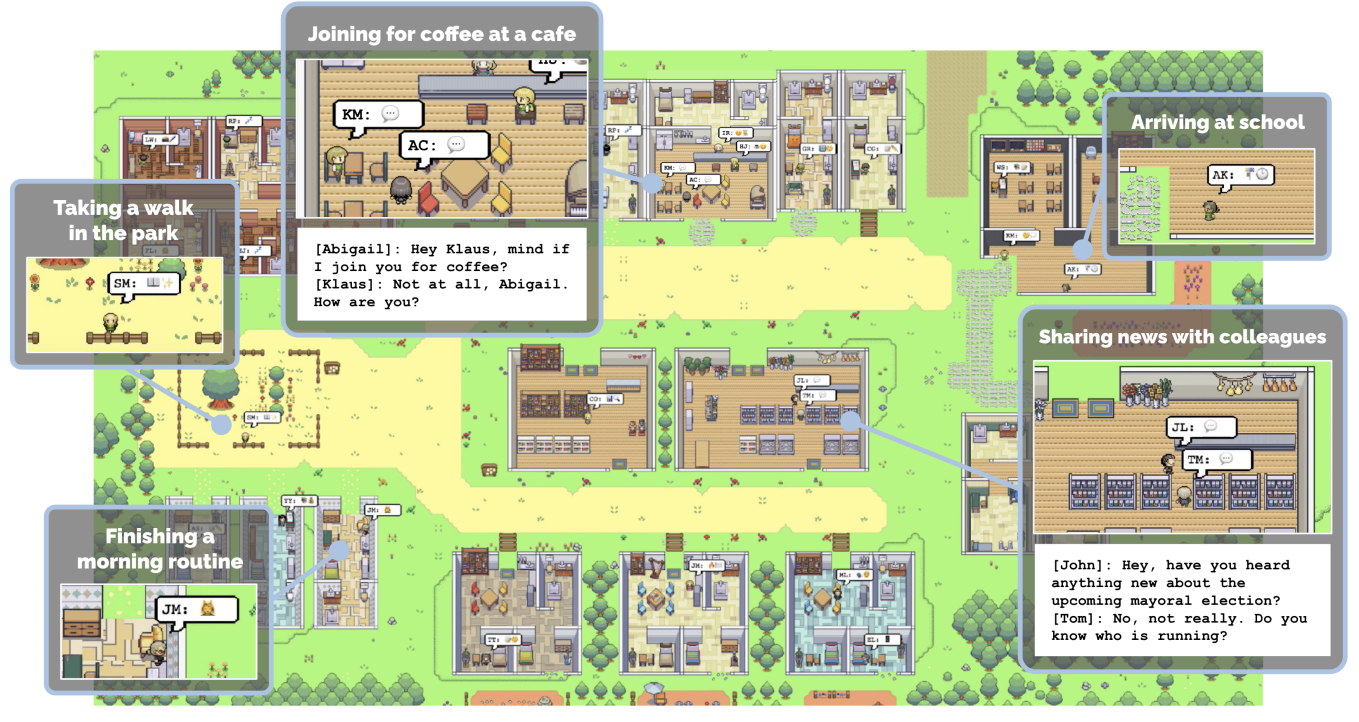

Рисунок 1. Генеративные агенты - это правдоподобные симулякры человеческого поведения для интерактивных приложений. В данной работе мы демонстрируем работу
генеративных агентов, заселив двадцатью пятью агентами среду "песочницы", напоминающую The Sims. Пользователи могут наблюдать
наблюдать и вмешиваться в работу агентов, планирующих свой день, обменивающихся новостями, формирующих отношения и координирующих групповые действия.

## Агенты LLM . Пример использования

Агенты на основе LLM являются мощными решателями общих задач.

В состав [первичных компонентов LLM-агентов](https://lilianweng.github.io/posts/2023-06-23-agent/) входят, по крайней мере, 3 вещи:

* `Планирование`: способность разбивать задачи на более мелкие подцели
* `Память`: Способность сохранять и вспоминать информацию
* `Инструменты`: Способность получать информацию из внешних источников (например, API).

В отличие от LLM, просто подключенных к APIs, агенты [могут](https://www.youtube.com/watch?v=DWUdGhRrv2c):

* Самокорректироваться
* Решать многоходовые задачи (несколько промежуточных "хопов" или шагов для получения вывода)
* решать задачи с большим временным горизонтом (требующие доступа к долговременной памяти)

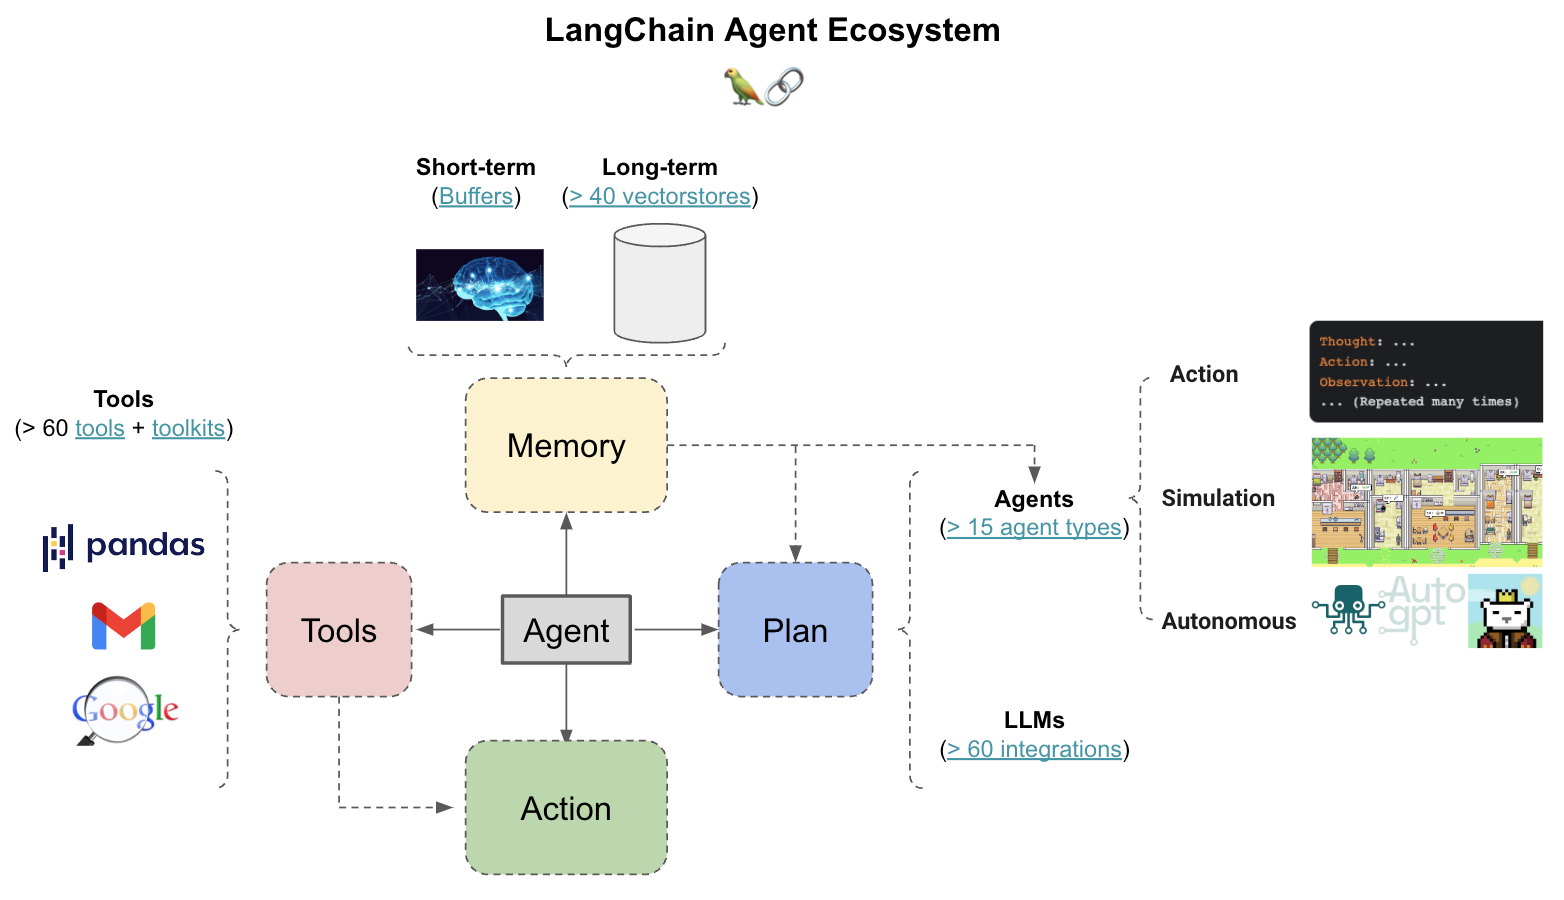


## Обзор

В LangChain существует [множество типов агентов](https://python.langchain.com/docs/modules/agents/agent_types/).

Почти все агенты будут использовать следующие компоненты:

**Планирование**.

* `Prompt`: Может задаваться LLM [личностью](https://arxiv.org/pdf/2304.03442.pdf), контекстом (например, через извлечение из памяти) или стратегиями обучения (например, [chain-of-thought](https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/#chain-of-thought-cot)).
* `Агент` Отвечает за принятие решения о том, какой шаг следует сделать дальше, используя LLM с ``программой``.

**Память*

* Она может быть кратковременной или долговременной, что позволяет агенту сохранять информацию.

**Инструменты**

* Инструменты - это функции, которые может вызывать агент.

Однако существуют некоторые таксономические различия:

* `Агенты действия`: Предназначены для принятия решений о последовательности действий (использования инструментов) (например, агенты функций OpenAI, агенты ReAct).
* `Симуляционные агенты`: Предназначены для ролевых игр в моделируемой среде (например, Generative Agents, CAMEL).
* `Автономные агенты`: Предназначены для самостоятельного выполнения долгосрочных задач (например, BabyAGI, Auto-GPT).

Речь пойдет об `Action-агентах`.

In [2]:
import ipywidgets as widgets
from IPython.display import display
import os

def on_button_click(b):
    os.environ['OPENAI_API_KEY'] = key_input.value
    print("Ключ OpenAI_API установлен!")

key_input = widgets.Password(
    placeholder='Введите ваш ключ API здесь',
    description='API ключ:',
    disabled=False
)
apply_button = widgets.Button(description="Применить")
apply_button.on_click(on_button_click)
display(key_input, apply_button)


Password(description='API ключ:', placeholder='Введите ваш ключ API здесь')

Button(description='Применить', style=ButtonStyle())

Ключ OpenAI_API установлен!


In [ ]:
openai_api_key = key_input.value
os.environ['OPENAI_API_KEY'] = openai_api_key


Для получения ключа API от SerpAPI выполните следующие шаги:

1. **Регистрация на SerpAPI**:
   - Перейдите на [официальный сайт SerpAPI](https://serpapi.com/).
   - Зарегистрируйтесь на сайте.

2. **Получение ключа API**:
   - После регистрации и входа в систему, перейдите в раздел аккаунта или настройки профиля.
   - В этом разделе должен быть предоставлен ваш уникальный ключ API. Обычно он выглядит как длинная строка символов.

3. **Использование ключа API**:
   - Когда у вас есть ключ, вы можете использовать его в вашем коде, передавая его при инициализации `SerpAPIWrapper` или установив его как переменную окружения, как я показал ранее.

**Примечание**: Обратите внимание, что SerpAPI может предоставить вам бесплатный период на пробное использование, но после истечения этого периода вам, возможно, потребуется оплатить услуги для продолжения использования API.


In [5]:
def handle_submit(sender):
    print("Ключ Serp_API установлен!")

# Создайте поле для ввода пароля (ключа API для SerpAPI)
serpapi_key_input = widgets.Password(
    placeholder='Введите ваш ключ API от SerpAPI здесь',
    description='SerpAPI ключ:',
    disabled=False
)
serpapi_key_input.on_submit(handle_submit)
display(serpapi_key_input)

Password(description='SerpAPI ключ:', placeholder='Введите ваш ключ API от SerpAPI здесь')

Ключ Serp_API установлен!


In [8]:
os.environ['SERPAPI_API_KEY'] = serpapi_key_input.value

In [6]:
! pip install langchain openai google-search-results

`Tools`

LangChain имеет [много инструментов](https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/agents/load_tools.py) для Агентов, которые мы можем легко загрузить.

Загрузим поиск и калькулятор.

In [9]:
# Tool
from langchain.agents import load_tools
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(temperature=0)
tools = load_tools(["serpapi", "llm-math"], llm=llm)

`Агент`

Агент [`OPENAI_FUNCTIONS` agent](https://python.langchain.com/docs/modules/agents/agent_types/openai_functions_agent) является хорошим агентом для начала работы.

Модели OpenAI были настроены таким образом, чтобы распознавать, когда следует вызывать функцию.

In [10]:
# Prompt
from langchain.agents import AgentExecutor
from langchain.schema import SystemMessage
from langchain.agents import OpenAIFunctionsAgent
system_message = SystemMessage(content="You are a search assistant.")
prompt = OpenAIFunctionsAgent.create_prompt(system_message=system_message)

# Agent
search_agent = OpenAIFunctionsAgent(llm=llm, tools=tools, prompt=prompt)
agent_executor = AgentExecutor(agent=search_agent, tools=tools, verbose=False)

# Run
agent_executor.run("How many people live in canada as of 2023?")

'As of 2023, the estimated population of Canada is approximately 38,781,291 people.'

Мы создали простой поисковый агент с помощью инструмента.

Обратите внимание, что мы используем agent executor, который является runtime for an agent.

Именно он вызывает агента и выполняет выбранные им действия.

Псевдокод для этой среды выполнения приведен ниже:
```
next_action = agent.get_action(...)
while next_action != AgentFinish:
    observation = run(next_action)
    next_action = agent.get_action(..., next_action, observation)
return next_action
```

Есть несколько сложностей, которые решает эта среда выполнения, в том числе:

* Обработка случаев, когда агент выбирает несуществующий инструмент.
* Обработка случаев, когда инструмент ошибается
* Обработка случаев, когда агент производит вывод, который не может быть разобран на вызов инструмента
* Протоколирование и наблюдаемость на всех уровнях (решения агента, вызовы инструмента) в stdout или LangSmith.


## Память

### Кратковременная память

Разумеется, `память` необходима для обеспечения возможности общения/сохранения информации.

LangChain имеет множество вариантов [кратковременной памяти](https://python.langchain.com/docs/modules/memory/types/), которые часто используются в [чате](/docs/modules/memory/adding_memory.html).

Они также могут быть [задействованы в агентах](https://python.langchain.com/docs/modules/memory/agent_with_memory).

Для кратковременной памяти часто используется `ConversationBufferMemory`.

Мы задаем `MEMORY_KEY`, на который в дальнейшем может ссылаться подсказка.

Теперь добавим память нашему агенту.

In [11]:
# Memory
from langchain.memory import ConversationBufferMemory
MEMORY_KEY = "chat_history"
memory = ConversationBufferMemory(memory_key=MEMORY_KEY, return_messages=True)

# Prompt w/ placeholder for memory
from langchain.schema import SystemMessage
from langchain.agents import OpenAIFunctionsAgent
from langchain.prompts import MessagesPlaceholder
system_message = SystemMessage(content="You are a search assistant tasked with using Serpapi to answer questions.")
prompt = OpenAIFunctionsAgent.create_prompt(
    system_message=system_message,
    extra_prompt_messages=[MessagesPlaceholder(variable_name=MEMORY_KEY)]
)

# Agent
search_agent_memory = OpenAIFunctionsAgent(llm=llm, tools=tools, prompt=prompt, memory=memory)
agent_executor_memory = AgentExecutor(agent=search_agent_memory, tools=tools, memory=memory, verbose=False)

In [12]:
agent_executor_memory.run("How many people live in Canada as of August, 2023?")

'As of August 2023, the estimated population of Canada is approximately 38,781,291 people.'

In [13]:
agent_executor_memory.run("What is the population of its largest provence as of August, 2023?")

'As of August 2023, the largest province in Canada is Ontario, with a population of more than 15 million people.'

Глядя на [trace](https://smith.langchain.com/public/4425a131-ec90-4aaa-acd8-5b880c7452a3/r), мы видим, что происходит:

* История чата передается в LLM.
* Это придает контекст фразе `its` в выражении `Каково население самой большой провинции страны по состоянию на август 2023 года?
* LLM генерирует вызов функции к инструменту поиска

```
function_call:
  имя: Search
  аргументы: |-
    {
      "query": "население крупнейшей провинции Канады по состоянию на август 2023 года"
    }
```

* Выполняется поиск
* Результаты поиска передаются обратно в LLM для синтеза в ответ

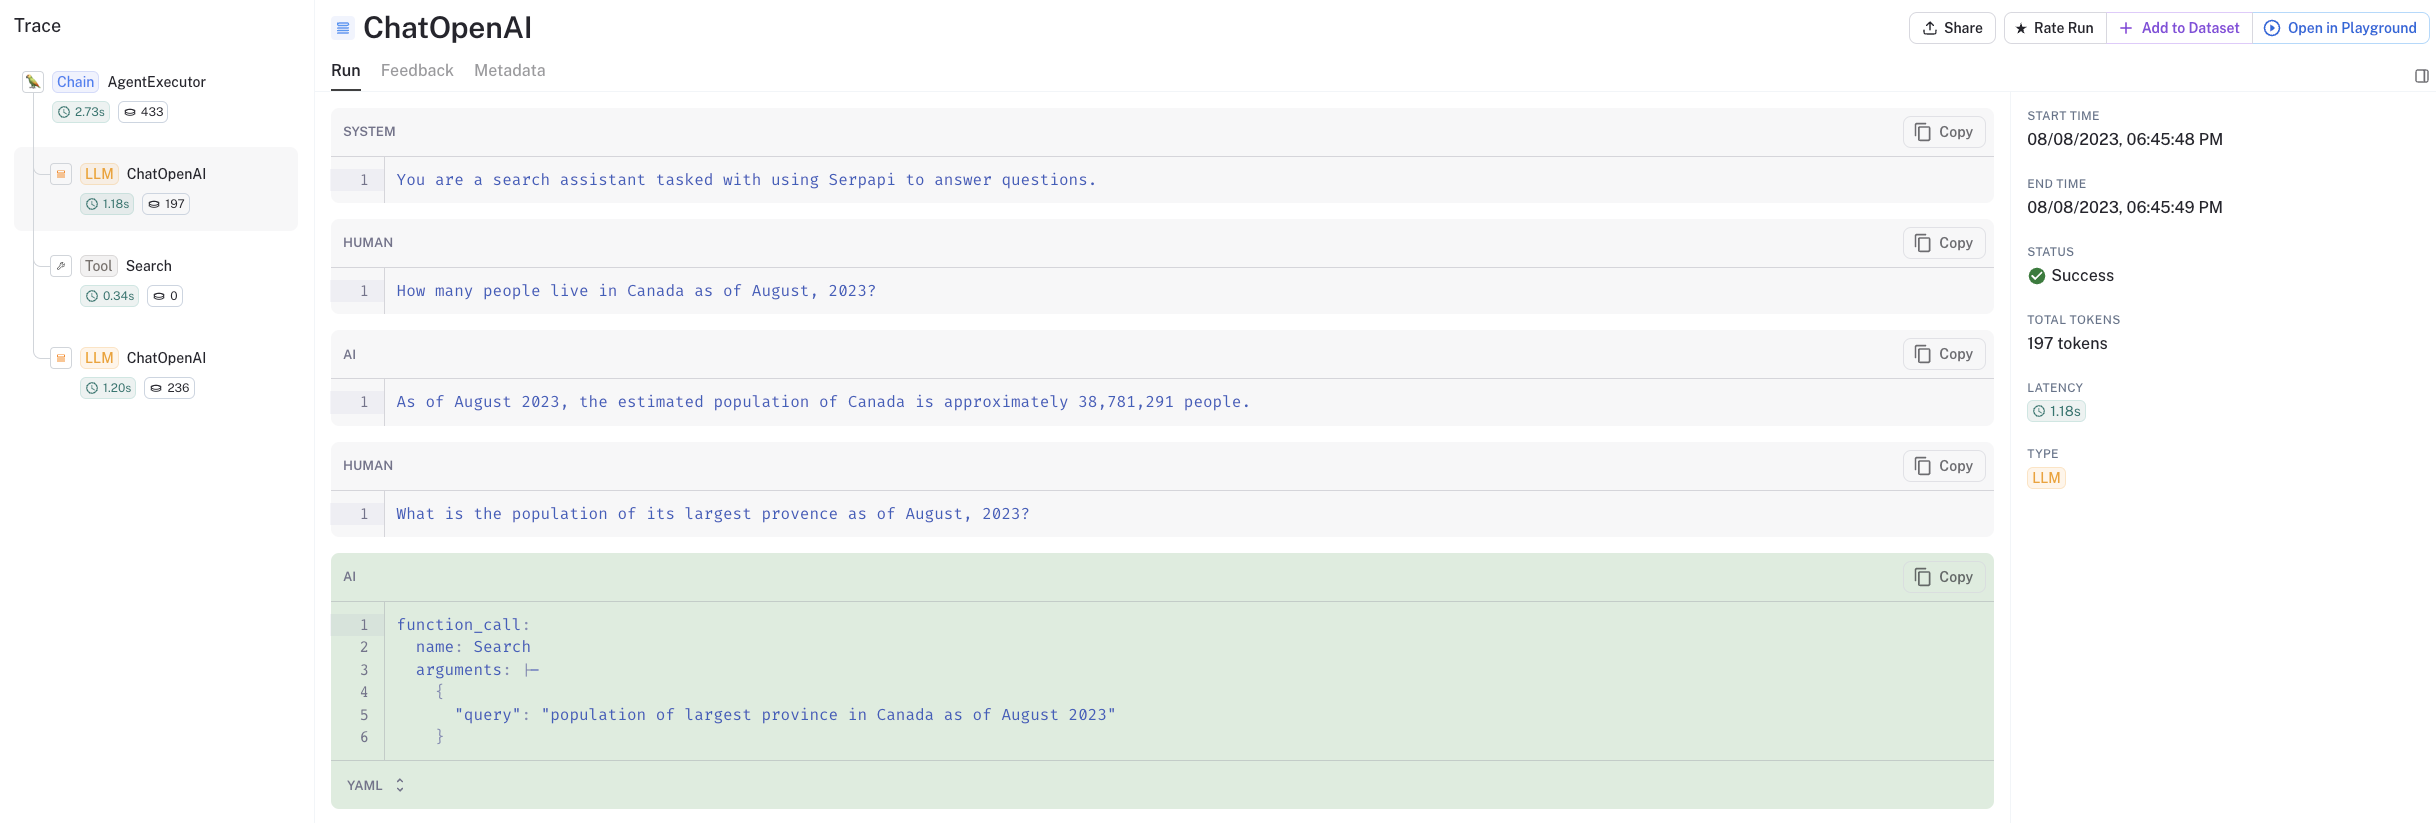

### Long-term memory

Vectorstores - отличный вариант для долговременной памяти.

In [15]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 76.2 MB/s eta 0:00:00


In [16]:
import faiss
from langchain.vectorstores import FAISS
from langchain.docstore import InMemoryDocstore
from langchain.embeddings import OpenAIEmbeddings
embedding_size = 1536
embeddings_model = OpenAIEmbeddings()
index = faiss.IndexFlatL2(embedding_size)
vectorstore = FAISS(embeddings_model.embed_query, index, InMemoryDocstore({}), {})

## Tools

У LangChain имеется [множество инструментов](https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/agents/load_tools.py) для Агентов, которые мы можем легко загрузить.

Мы также можем определить [пользовательские инструменты](https://python.langchain.com/docs/modules/agents/tools/custom_tools). Например, вот инструмент поиска.

* Класс данных `Tool` оборачивает функции, которые принимают на вход одну строку и возвращают на выходе строку.
* `return_direct` определяет, следует ли возвращать вывод инструмента напрямую.
* Установка этого значения в `True` означает, что после вызова инструмента `AgentExecutor` прекратит выполнение цикла.

#Как получить ключ API от Google:
Перейдите на Google Cloud Console.

Если у вас нет проекта, создайте новый проект.

В левом боковом меню выберите "Credentials" (Учетные данные).
Нажмите на кнопку "Create Credentials" (Создать учетные данные) и выберите "API key" (Ключ API).

После создания ключа API скопируйте и сохраните его в безопасном месте.

Теперь, чтобы использовать этот ключ для определенных Google Services (например, поиска), вам также может потребоваться включить соответствующие API в разделе "Library" (Библиотека).

In [18]:
import ipywidgets as widgets
from IPython.display import display

def handle_google_key_submit(sender):
    print("Ключ API от Google успешно введен!")

# Создайте поле для ввода пароля (ключа API для Google)
google_key_input = widgets.Password(
    placeholder='Введите ваш ключ API от Google здесь',
    description='Google API ключ:',
    disabled=False
)
google_key_input.on_submit(handle_google_key_submit)
display(google_key_input)


Password(description='Google API ключ:', placeholder='Введите ваш ключ API от Google здесь')

Ключ API от Google успешно введен!


In [20]:
os.environ['GOOGLE_API_KEY'] = google_key_input.value

Google Custom Search Engine (CSE) позволяет создавать пользовательский поисковый движок для своего сайта или набора сайтов. Если вы планируете использовать Google Search API, вам потребуется идентификатор CSE.

Вот как вы можете получить его:

Перейдите на [Google Custom Search homepage](https://programmablesearchengine.google.com/about/).
    
Нажмите "Создать новый поисковый движок" или выберите существующий.
    
Введите детали вашего поискового движка (например, какие сайты искать).
   
После создания или выбора поискового движка, в верхней части страницы увидите идентификатор вашего CSE (называемый "Идентификатор поискового движка").

[Активируйте Custom Search API для вашего проекта](https://console.developers.google.com/apis/api/customsearch.googleapis.com/)


In [22]:
def handle_google_cse_id_submit(sender):
    print("Идентификатор CSE успешно введен!")

# Создайте поле для ввода идентификатора CSE
google_cse_id_input = widgets.Password(
    placeholder='Введите ваш идентификатор CSE здесь',
    description='Google CSE ID:',
    disabled=False
)
google_cse_id_input.on_submit(handle_google_cse_id_submit)
display(google_cse_id_input)


Password(description='Google CSE ID:', placeholder='Введите ваш идентификатор CSE здесь')

Идентификатор CSE успешно введен!


In [24]:
os.environ['GOOGLE_CSE_ID'] = google_cse_id_input.value

In [25]:
from langchain.agents import Tool, tool
from langchain.utilities import GoogleSearchAPIWrapper
search = GoogleSearchAPIWrapper()
search_tool = [
    Tool(
        name="Search",
        func=search.run,
        description="useful for when you need to answer questions about current events",
        return_direct=True,
    )
]

Для облегчения определения пользовательских инструментов предусмотрен декоратор `@tool`.

Этот декоратор можно использовать для быстрого создания инструмента из простой функции.

In [26]:
# Tool
@tool
def get_word_length(word: str) -> int:
    """Returns the length of a word."""
    return len(word)
word_length_tool = [get_word_length]

**Наборы инструментов**

* Наборы инструментов - это группы инструментов, необходимых для решения конкретных задач.
* [Здесь](https://python.langchain.com/docs/integrations/toolkits/) находятся > 15 различных наборов инструментов для агентов (например, Gmail, Pandas и т.д.).

Вот простой способ представить себе агентов в сравнении с различными цепочками, рассматриваемыми в других документах:

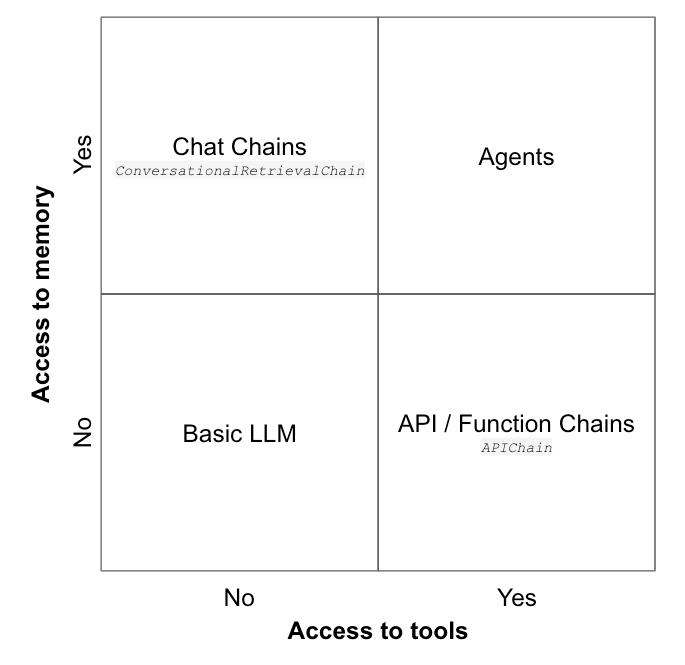

## Агенты

В LangChain существует несколько типов [агентов действия](https://python.langchain.com/docs/use_cases/more/agents/docs/modules/agents/agent_types/).

* [ReAct](https://python.langchain.com/docs/modules/agents/agent_types/react.html): Это наиболее универсальный агент, использующий фреймворк [ReAct](https://arxiv.org/pdf/2205.00445.pdf), который может работать с [Docstores](https://python.langchain.com/docs/modules/agents/agent_types/react_docstore.html) или [Multi-tool Inputs](https://python.langchain.com/docs/modules/agents/agent_types/structured_chat.html).
* [Функции OpenAI](https://python.langchain.com/docs/modules/agents/agent_types/openai_functions_agent.html): Предназначен для работы с моделями вызова функций OpenAI.
* [Conversational](https://python.langchain.com/docs/modules/agents/agent_types/chat_conversation_agent.html): Этот агент предназначен для использования в разговорной среде
* [Self-ask with search](/https://python.langchain.com/docs/modules/agents/agent_types/self_ask_with_search.html): Предназначен для поиска фактических ответов на вопросы

### Агент OpenAI Functions

Как показано в Quickstart, продолжим работу с [агентом `OpenAI functions`](https://python.langchain.com/docs/modules/agents/agent_types/self_ask_with_search.html).

В нем используются модели OpenAI, настроенные таким образом, чтобы определять, когда необходимо вызвать ту или иную функцию.

В ответ они передают входные данные, которые должны быть переданы функции.

Но сначала мы можем распаковать его, используя пользовательскую подсказку:

In [27]:
# Memory
MEMORY_KEY = "chat_history"
memory = ConversationBufferMemory(memory_key=MEMORY_KEY, return_messages=True)

# Prompt
from langchain.schema import SystemMessage
from langchain.agents import OpenAIFunctionsAgent
system_message = SystemMessage(content="You are very powerful assistant, but bad at calculating lengths of words.")
prompt = OpenAIFunctionsAgent.create_prompt(
    system_message=system_message,
    extra_prompt_messages=[MessagesPlaceholder(variable_name=MEMORY_KEY)]
)

Define agent:

In [28]:
# Agent
from langchain.agents import OpenAIFunctionsAgent
agent = OpenAIFunctionsAgent(llm=llm, tools=word_length_tool, prompt=prompt)

Run agent:

In [29]:
# Run the executer, including short-term memory we created
agent_executor = AgentExecutor(agent=agent, tools=word_length_tool, memory=memory, verbose=False)
agent_executor.run("how many letters in the word educa?")

'There are 5 letters in the word "educa".'

### ReAct agent

Агенты [ReAct](https://arxiv.org/abs/2210.03629) - еще один популярный фреймворк.

Существует много работ по [LLM reasoning](https://ai.googleblog.com/2022/05/language-models-perform-reasoning-via.html), например, по цепочке мыслей.

Также были работы по LLM-действиям для генерации наблюдений, например [Say-Can](https://say-can.github.io/).

ReAct объединяет эти две идеи:
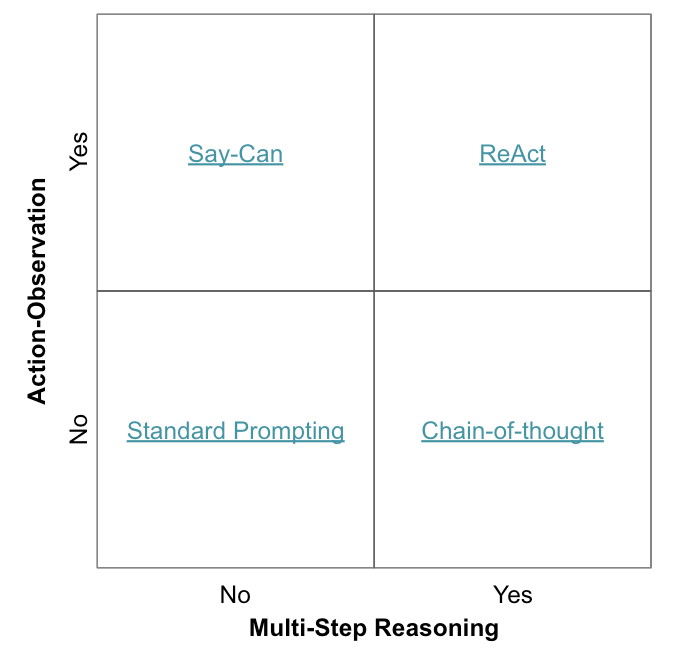


`Thought`, `Action`, `Observation` [pattern in the output](https://lilianweng.github.io/posts/2023-06-23-agent/).

Мы можем использовать `initialize_agent` для создания агента ReAct из списка доступных типов [здесь](https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/agents/types.py):

```
* AgentType.ZERO_SHOT_REACT_DESCRIPTION: ZeroShotAgent
* AgentType.REACT_DOCSTORE: ReActDocstoreAgent
* AgentType.SELF_ASK_WITH_SEARCH: SelfAskWithSearchAgent
* AgentType.CONVERSATIONAL_REACT_DESCRIPTION: ConversationalAgent
* AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION: ChatAgent
* AgentType.CHAT_CONVERSATIONAL_REACT_DESCRIPTION: ConversationalChatAgent
* AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION: StructuredChatAgent
* AgentType.OPENAI_FUNCTIONS: OpenAIFunctionsAgent
* AgentType.OPENAI_MULTI_FUNCTIONS: OpenAIMultiFunctionsAgent
```

In [30]:
from langchain.agents import AgentType
from langchain.agents import initialize_agent
MEMORY_KEY = "chat_history"
memory = ConversationBufferMemory(memory_key=MEMORY_KEY, return_messages=True)
react_agent = initialize_agent(search_tool, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=False, memory=memory)

In [32]:
react_agent("How many people live in Canada as of August, 2023?")

{'input': 'How many people live in Canada as of August, 2023?',
 'chat_history': [HumanMessage(content='How many people live in Canada as of August, 2023?', additional_kwargs={}, example=False),
  AIMessage(content="The current population of Canada is 38,855,947 as of Saturday, September 23, 2023, based on Worldometer elaboration of the latest United Nations data 1. · Canada\xa0... Jul 1, 2023 ... The U.S. Census Bureau's International Database estimates the July 1, 2023, population of Canada at 38.5M (4.2 people per sq. km) and the\xa0... Quarterly population estimate - Canada (Note) (April 1, 2023). 39,858,480. 0.7% increase. (quarterly change). Consumer Price Index - Canada (August 2023). 4.0\xa0... Dec 13, 2022 ... ... 2023. Press Release. CPS Table Packages Now Available. August 29, 2023. The U.S. Census Bureau released new tables from the 2022 Current\xa0... Index to the latest information from the Census of Population. This survey ... 22. Aug. 2023. Insights on Canadian Society:

In [33]:
react_agent("What is the population of its largest provence as of August, 2023?")

{'input': 'What is the population of its largest provence as of August, 2023?',
 'chat_history': [HumanMessage(content='How many people live in Canada as of August, 2023?', additional_kwargs={}, example=False),
  AIMessage(content="The current population of Canada is 38,855,947 as of Saturday, September 23, 2023, based on Worldometer elaboration of the latest United Nations data 1. · Canada\xa0... Jul 1, 2023 ... The U.S. Census Bureau's International Database estimates the July 1, 2023, population of Canada at 38.5M (4.2 people per sq. km) and the\xa0... Quarterly population estimate - Canada (Note) (April 1, 2023). 39,858,480. 0.7% increase. (quarterly change). Consumer Price Index - Canada (August 2023). 4.0\xa0... Dec 13, 2022 ... ... 2023. Press Release. CPS Table Packages Now Available. August 29, 2023. The U.S. Census Bureau released new tables from the 2022 Current\xa0... Index to the latest information from the Census of Population. This survey ... 22. Aug. 2023. Insights on C

LangSmith может помочь нам провести диагностику агента ReAct:

Агент [ReAct](https://smith.langchain.com/public/3d8d0a15-d73f-44f3-9f81-037f7031c592/r) не может передать историю чата в LLM, получает неправильный ответ.

Агент OAI functions это делает и [получает правильный ответ](https://smith.langchain.com/public/4425a131-ec90-4aaa-acd8-5b880c7452a3/r), как показано выше.

Кроме того, результат работы поискового инструмента для [ReAct](https://smith.langchain.com/public/6473e608-fc9d-47c9-a8a4-2ef7f2801d82/r) хуже, чем для [OAI](https://smith.langchain.com/public/4425a131-ec90-4aaa-acd8-5b880c7452a3/r/26b85fa9-e33a-4028-8650-1714f8b3db96).

В совокупности это говорит нам: внимательно изучайте трассировки агентов и результаты работы инструментов.

Как мы видели на примере [SQL](/docs/use_cases/qa_structured/sql), агенты `ReAct` могут очень хорошо работать для решения конкретных задач.

Но, как показано здесь, результат ухудшается по сравнению с тем, что мы видим при использовании агента OpenAI.

### Custom

Давайте пойдем еще дальше, чтобы определить собственный агент действия.

Мы можем [create a custom agent] (https://python.langchain.com/docs/modules/agents/how_to/custom_agent.html) распаковать центральные части:

* `Tools`: Инструменты, доступные агенту для использования
* `Agent`: решает, какое действие предпринять

In [35]:
from typing import List, Tuple, Any, Union
from langchain.schema import AgentAction, AgentFinish
from langchain.agents import Tool, AgentExecutor, BaseSingleActionAgent

class FakeAgent(BaseSingleActionAgent):
    """Fake Custom Agent."""

    @property
    def input_keys(self):
        return ["input"]

    def plan(
        self, intermediate_steps: List[Tuple[AgentAction, str]], **kwargs: Any
    ) -> Union[AgentAction, AgentFinish]:
        """Given input, decided what to do.

        Args:
            intermediate_steps: Steps the LLM has taken to date,
                along with observations
            **kwargs: User inputs.

        Returns:
            Action specifying what tool to use.
        """
        return AgentAction(tool="Search", tool_input=kwargs["input"], log="")

    async def aplan(
        self, intermediate_steps: List[Tuple[AgentAction, str]], **kwargs: Any
    ) -> Union[AgentAction, AgentFinish]:
        """Given input, decided what to do.

        Args:
            intermediate_steps: Steps the LLM has taken to date,
                along with observations
            **kwargs: User inputs.

        Returns:
            Action specifying what tool to use.
        """
        return AgentAction(tool="Search", tool_input=kwargs["input"], log="")

fake_agent = FakeAgent()
fake_agent_executor = AgentExecutor.from_agent_and_tools(agent=fake_agent,
                                                         tools=search_tool,
                                                         verbose=False)

fake_agent_executor.run("How many people live in canada as of 2023?")

'Population of Canada: current, historical, and projected population, growth rate, immigration, median age, total fertility rate (TFR), population density,\xa0... Mar 22, 2023 ... Canada\'s population was estimated at 39,566,248 on January 1, 2023 ... population growth in 2022, as it has been the case for many years. Jun 19, 2023 ... As of June 16, 2023, there are now 40 million Canadians! This is a historic milestone for Canada and certainly cause for celebration. Jun 28, 2023 ... Demographic estimates for Canada, the provinces and the territories on April 1, 2023 are now available. These new data allow for an analysis\xa0... Canada ranks 37th by population among countries of the world, comprising about 0.5% of the world\'s total, with almost 40.0 million Canadians as of 2023. Jun 28, 2023 ... © His Majesty the King in Right of Canada, as represented by the Minister of Industry, 2023 ... You have sent too many messages. Please wait some\xa0... Chart and table of Canada population from

## Runtime

Класс `AgentExecutor` является основной средой выполнения агентов, поддерживаемой LangChain.

Однако существуют и другие, более экспериментальные среды выполнения для `автономных_агентов`:

* Plan-and-execute Agent
* Baby AGI
* Auto GPT

Подробнее о:

* `Simulation agents`: Предназначены для ролевых игр в симулированной среде (например, Generative Agents, CAMEL).
* `Autonomous agents`: Предназначены для самостоятельного выполнения долгосрочных задач (например, BabyAGI, Auto-GPT).

